# Importy i Dane

Poniżej skalujemy dane za pomocą MinMaxScaler, żeby je wszystkie przeskalować i żeby nie biasowało to

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import time

colnames = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
url = "car.data"
df = pd.read_csv(url, header=None, names=colnames)

maps = {
    'buying':   {'vhigh':3,'high':2,'med':1,'low':0},
    'maint':    {'vhigh':3,'high':2,'med':1,'low':0},
    'doors':    {'2':0,'3':1,'4':2,'5more':3},
    'persons':  {'2':0,'4':1,'more':2},
    'lug_boot': {'small':0,'med':1,'big':2},
    'safety':   {'low':0,'med':1,'high':2},
    'class':    {'unacc':0,'acc':1,'good':2,'vgood':3}
}
df_ord = df.replace(maps)

X = df_ord.drop('class', axis=1).values
y = df_ord['class'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


C:\Users\jakub\AppData\Local\Temp\ipykernel_339124\650252984.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ord = df.replace(maps)


# Implementacja algorytmu Kohonen'a

Zainicjowano siatkę SOM: 15x15 dla danych 6-wymiarowych.
Rozpoczynam trening (może chwilę potrwać)...
Iteracja 0/1000, Promień: 7.50
Iteracja 100/1000, Promień: 6.75
Iteracja 200/1000, Promień: 6.00
Iteracja 300/1000, Promień: 5.25
Iteracja 400/1000, Promień: 4.50
Iteracja 500/1000, Promień: 3.75
Iteracja 600/1000, Promień: 3.00
Iteracja 700/1000, Promień: 2.25
Iteracja 800/1000, Promień: 1.50
Iteracja 900/1000, Promień: 0.75
Trening zakończony w 0.53 s.

--- Wyniki ---
Błąd kwantyzacji (QE): 0.5467
Błąd topograficzny (TE): 0.0683


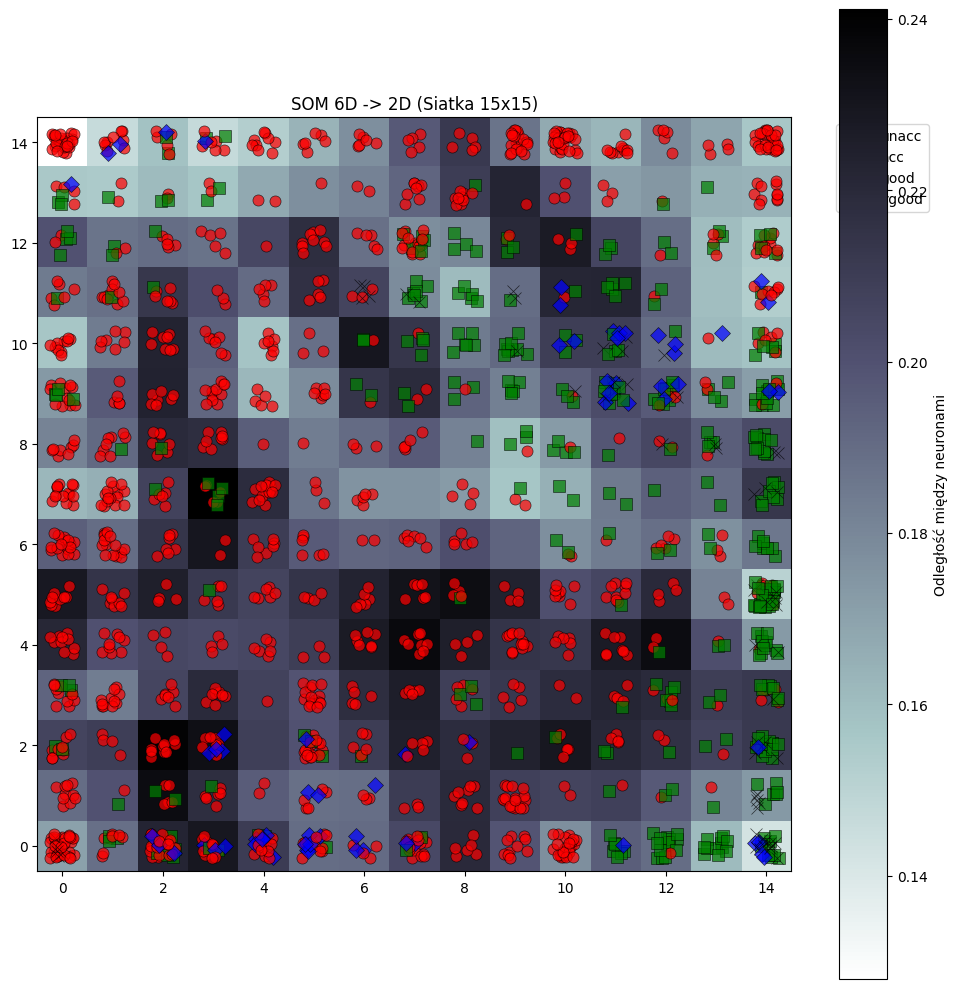

In [ ]:

def dist_nd(p1, p2):
    return np.sum((p1 - p2)**2)

def phi(ix, iy, kx, ky, d):
    return np.exp(-((ix - kx)**2 + (iy - ky)**2) / (d**2))

grid_size = 15
input_dim = 6
rounds = 1000
learning_rate = 0.5
radius = grid_size / 2.0


np.random.seed(42)
weights = np.random.rand(grid_size, grid_size, input_dim)

print(f"Zainicjowano siatkę SOM: {grid_size}x{grid_size} dla danych {input_dim}-wymiarowych.")

print("Rozpoczynam trening")
start_time = time.time()

num_samples = X_scaled.shape[0]

for iteration in range(rounds):
    curr_rate = learning_rate * (1 - iteration / rounds)
    curr_radius = radius * (1 - iteration / rounds)
    
    if curr_radius < 0.1:
        curr_radius = 0.1

    idx = np.random.randint(0, num_samples)
    sample = X_scaled[idx]
    
    dists = np.sum((weights - sample)**2, axis=2)
    bmu_idx = np.argmin(dists)
    bmu_x, bmu_y = np.unravel_index(bmu_idx, (grid_size, grid_size))
    
    start_x = max(0, int(bmu_x - curr_radius * 3))
    end_x = min(grid_size, int(bmu_x + curr_radius * 3 + 1))
    start_y = max(0, int(bmu_y - curr_radius * 3))
    end_y = min(grid_size, int(bmu_y + curr_radius * 3 + 1))

    for i in range(start_x, end_x):
        for j in range(start_y, end_y):
            influence = phi(bmu_x, bmu_y, i, j, curr_radius)
            
            weights[i, j] += curr_rate * influence * (sample - weights[i, j])

    if iteration % 100 == 0:
        print(f"Iteracja {iteration}/{rounds}, Promień: {curr_radius:.2f}")

print(f"Trening zakończony w {time.time() - start_time:.2f} s.")

qe_sum = 0
for x in X_scaled:
    dists = np.sum((weights - x)**2, axis=2)
    qe_sum += np.sqrt(np.min(dists))
quantization_error = qe_sum / num_samples


te_count = 0
for x in X_scaled:
    dists = np.sum((weights - x)**2, axis=2)
    flat_indices = np.argsort(dists, axis=None)
    
    bmu1 = np.unravel_index(flat_indices[0], (grid_size, grid_size))
    bmu2 = np.unravel_index(flat_indices[1], (grid_size, grid_size))
    
    grid_dist = np.sqrt((bmu1[0]-bmu2[0])**2 + (bmu1[1]-bmu2[1])**2)
    
    if grid_dist > np.sqrt(2):
        te_count += 1
topographic_error = te_count / num_samples

print(f"\n--- Wyniki ---")
print(f"Błąd kwantyzacji (QE): {quantization_error:.4f}")
print(f"Błąd topograficzny (TE): {topographic_error:.4f}")


u_matrix = np.zeros((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        nb_dists = []
        if i > 0: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i-1,j])))
        if i < grid_size-1: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i+1,j])))
        if j > 0: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i,j-1])))
        if j < grid_size-1: nb_dists.append(np.sqrt(dist_nd(weights[i,j], weights[i,j+1])))
        
        u_matrix[i, j] = np.mean(nb_dists)

plt.figure(figsize=(10, 10))
plt.imshow(u_matrix.T, cmap='bone_r', origin='lower')
plt.colorbar(label='Odległość między neuronami')

markers = ['o', 's', 'D', 'x']
colors = ['r', 'g', 'b', 'orange'] 

jitter = lambda: (np.random.rand() - 0.5) * 0.5 

for i, x in enumerate(X_scaled):
    dists = np.sum((weights - x)**2, axis=2)
    bmu_idx = np.argmin(dists)
    bx, by = np.unravel_index(bmu_idx, (grid_size, grid_size))
    
    plt.plot(bx + jitter(), by + jitter(), 
             marker=markers[y[i]], 
             color=colors[y[i]], 
             markersize=8, 
             markeredgecolor='black',
             markeredgewidth=0.5,
             alpha=0.7)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker=m, color='w', label=l,
                          markerfacecolor=c, markeredgecolor='k', markersize=10) 
                   for m, c, l in zip(markers, colors, ['unacc', 'acc', 'good', 'vgood'])]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title(f"SOM 6D -> 2D (Siatka {grid_size}x{grid_size})")
plt.tight_layout()
plt.show()